# Modify a radio map

1. Downsampling can be done by just increasing the cell size when generating the radio map.
2. We can modify specific sections of the radio map by changing the scene value of path gain for specific areas.

In [1]:
from sionna.rt import load_scene, Camera, RadioMapSolver

from builders import SceneTransceiverBuilder
from builders import TransceiverConfig

In [2]:
# Load empty scene
scene = load_scene(None)
scene.frequency = 28e9  # Hz

In [3]:
# Use the builder to create a scene explicitly with directed antennas
builder = SceneTransceiverBuilder(scene)
cfg = TransceiverConfig.positioned(
    n_tx=1, n_rx=4,
    tx_positions=[[0,0,1]],
    rx_positions=[[-20,0,1],[20,0,1],[0,20,1],[0,-20,1]],
    look_at=[-20,0,1],
    tx_power_dbm=44,
    tx_array_pattern="tr38901",
    polarization="V",
    seed=42
)
builder.build(cfg)

In [4]:
rm_solver = RadioMapSolver()

# Compute high-resolution (HR) and low-resolution (LR) radio maps
rm_hr = rm_solver(scene, 
                  max_depth=5, 
                  samples_per_tx=10**7, 
                  cell_size=(5, 5), 
                  center=[0, 0, 0], 
                  size=[400, 400], 
                  orientation=[0, 0, 0])

rm_lr = rm_solver(scene,
                  max_depth=5,
                  samples_per_tx=10**7,
                  cell_size=(15, 15),
                  center=[0, 0, 0],
                  size=[400, 400],
                  orientation=[0, 0, 0])

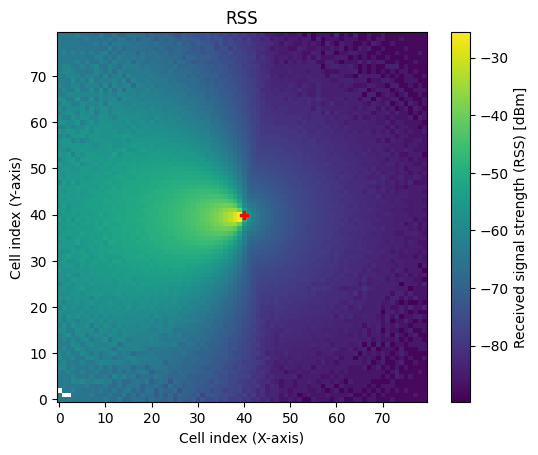

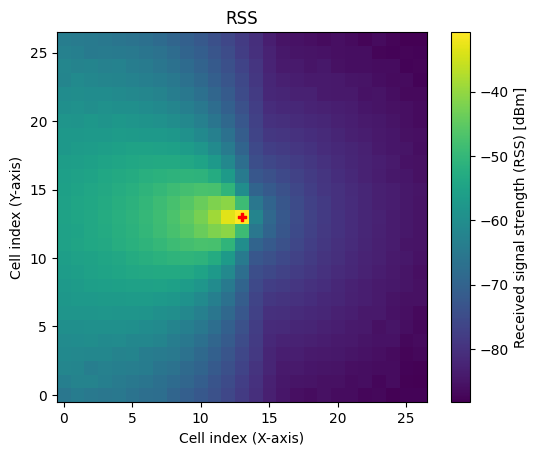

In [5]:
rm_hr.show(metric="rss");
rm_lr.show(metric="rss");

### Convert to torch tensor

In [6]:
print(type(rm_hr.rss))
rm_hr_torch = rm_hr.rss.torch()
print(type(rm_hr_torch))
print(rm_hr_torch.shape)  # [transmittors, x, y]

<class 'drjit.llvm.ad.TensorXf'>
<class 'torch.Tensor'>
torch.Size([1, 80, 80])


### Modify specific areas of the radio map

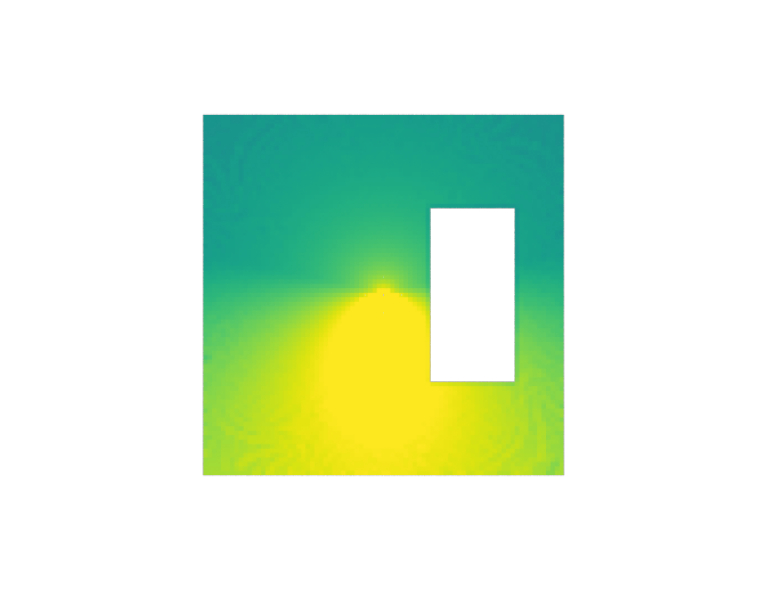

In [7]:
# Work on underlying path_gain (other metrics are derived; cannot assign to them)
pg = rm_hr.path_gain     # shape (n_tx, H, W)

# Zero rectangle in TX
pg[0, 10:30, 20:60] = 0.0   # <-- scalar broadcast

my_cam = Camera(position=[0, 0, 1000], look_at=[0, 0, 0])

_ = scene.render(
    camera=my_cam,
    radio_map=rm_hr,
    rm_metric="sinr",
    rm_vmin=-10,
    rm_vmax=60
)